### Implement PGD for constrained convex quadratic optimization

In this question, you will implement PGD
\begin{align*}
    x_{t+1} = \Pi_X(y_{t+1}), \quad y_{t+1} = x_t - \eta \nabla f(x_t)
\end{align*}
for a convex quadratic optimization 
\begin{equation}
    f(x) = \frac{1}{2}x^TQx + b^Tx
\end{equation}
with a positive semidefinite $Q$ by construction and a fixed $b$, over an $l_2-$ball
\begin{align*}
    X = \{x\in \mathbb{R}^d: \|x\|_2\leq r\}
\end{align*}
with an active $r$,
and compare it to the exact constrained optimum $f(x^*)$ from CVXPY. The codes for data generation, the CVXPY implementation, and comparation and plotting are already provided and should not be changed. Your task is to complete the two PGD functions and then run the script. (You can also use CVX in Matlab to generate $f(x^*)$ if you prefer, but we will not provide the codes. You need to copy $Q$ and $b$ to Matlab since they are fixed. )

You need to submit the code you wrote for the two functions \textbf{project\_l2\_ball} and \textbf{pgd\_l2}, \textbf{a plot of iteration versus optimality gap} $f(x_k) - f(x^*)$, and the \textbf{final value of PGD}. You are not required to submit any other codes beyond the two functions, as well as the file.

cvxpy: f(x*) = -0.05848522, ||x*|| = 0.106854
PGD:   f(x_T) = -0.05848520, ||x_T|| = 0.106854


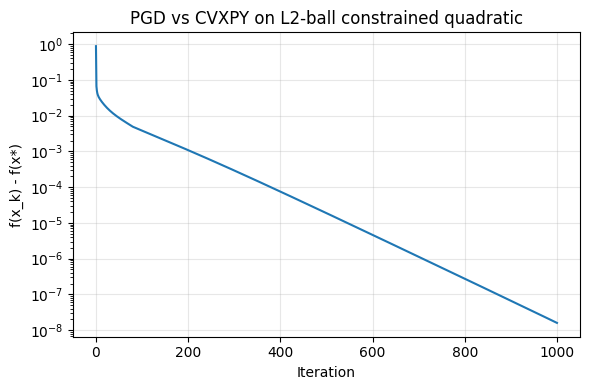

In [8]:
# Assignment 3 : 5. PGD on L2-ball constrained quadratic
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

def ganerate_Q_b(d=10, mu=1.0, L=400.0):
    eigs = np.geomspace(mu, L, d)                 
    Q = np.diag(eigs)                             
    Q = 0.5 * (Q + Q.T)                           
    b = np.array([(-1)**i * (i + 1) / d for i in range(d)], dtype=float)  
    return Q, b, eigs

# --- Objective and gradient ---
def f_quad(x, Q, b):
    return 0.5 * x @ (Q @ x) + b @ x

def grad_f_quad(x, Q, b):
    return Q @ x + b

# --- L2 projection ---
def project_l2_ball(x, r):
    """
    Implement your projection onto L2 ball here. 

    Inputs:
      x: point to project
      r: radius
    Returns:
      x_proj: projection of x onto L2 ball
    """
    #####################################
    # TODO: your code here
    dis = np.linalg.norm(x)
    if dis <= r :
        return x
    else :
        return r * x / dis
    #####################################

# --- PGD ---
def pgd_l2(grad_f, proj, x0, step, r, Q, b, iters=1200):
    """
    Implement your projected gradient descent here. 
    
    Inputs:
      grad_f: gradient function 
      proj: projection function onto L2 ball
      x0: initial point, will be projected
      step: step size
      r: radius
      Q, b: problem data
      iters: number of iterations
    Returns:
      x_T: last iterate
      f_hist: array of f(x_k) over iterations
    """
    #####################################
    # TODO: your code here
    x_t = np.zeros((iters + 1, x0.shape[0]))
    f_hist = np.zeros(iters + 1)
    x_t[0] = x0
    f_hist[0] = f_quad(x_t[0], Q, b)
    for i in range(1, iters + 1) :
        gd = grad_f(x_t[i - 1], Q, b)
        x_t[i] = proj(x_t[i - 1] - step * gd, r)
        f_hist[i] = f_quad(x_t[i], Q, b)
    
    return x_t[-1], f_hist
    #####################################

# --- CVXPY for constrained optimum ---
def solve_cvxpy_l2_ball(Q, b, r):
    d = Q.shape[0]
    x = cp.Variable(d)
    obj = 0.5 * cp.quad_form(x, Q) + b @ x
    cons = [cp.norm2(x) <= r]
    prob = cp.Problem(cp.Minimize(obj), cons)
    try:
        prob.solve(verbose=False)
    except Exception:
        prob.solve(verbose=False)
    if x.value is None:
        raise RuntimeError(f"CVXPY failed with status: {prob.status}")
    return x.value, float(f_quad(x.value, Q, b)), prob.status

# --- Build problem ---
d = 10
mu, L = 1.0, 400.0
Q, b, eigs = ganerate_Q_b(d=d, mu=mu, L=L)

# Radius: activate constraint
x_unc = -np.linalg.solve(Q, b)                   
r = 0.6 * np.linalg.norm(x_unc)

# --- CVXPY optimum ---
x_star, f_star, status = solve_cvxpy_l2_ball(Q, b, r)

# --- PGD from a random feasible start ---
rng = np.random.default_rng()                     
x0 = project_l2_ball(rng.normal(size=d), r)
eta = 1.0 / np.max(eigs)                          # 1/L
x_pgd, f_hist = pgd_l2(grad_f_quad, project_l2_ball, x0, eta, r, Q, b, iters=1000)

# --- Reports ---
print(f"cvxpy: f(x*) = {f_star:.8f}, ||x*|| = {np.linalg.norm(x_star):.6f}")
print(f"PGD:   f(x_T) = {f_hist[-1]:.8f}, ||x_T|| = {np.linalg.norm(x_pgd):.6f}")

# --- Plot convergence ---
plt.figure(figsize=(6,4))
plt.plot(np.maximum(f_hist - f_star, 1e-18))
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("f(x_k) - f(x*)")
plt.title("PGD vs CVXPY on L2-ball constrained quadratic")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Implement GD and Nesterov’s AGD for Logistic Regression

In this question, you will implement GD
\begin{align*}
    x_{t+1} = x_t-\eta \nabla f(x_t)
\end{align*}
and Nesterov’s AGD
\begin{align*}
    x_{t+1} = y_t-\eta \nabla f(y_t), \quad y_t = x_t + \gamma(x_t-x_{t-1})
\end{align*}
for logistic regression using Numpy and scikit-learn in Python. The dataset is the breast\_cancer from scikit-learn. The codes for data loading, the loss and its gradient, the training flow, and plotting are already provided and should not be changed. Your task is to complete the two gradient optimizer functions and then run the script.

You need to submit the code you wrote for the two optimizer functions \textbf{run\_gd} and \textbf{run\_agd}, \textbf{a plot of training loss} versus epoch for GD and AGD on the same figure, and the printed final \textbf{training and test accuracy} for both methods. You are not required to submit any other codes beyond the two functions, as well as the file. 

GD:  final train acc 0.9883, test acc 0.9650, final train loss 0.0849
AGD: final train acc 0.9883, test acc 0.9580, final train loss 0.0497


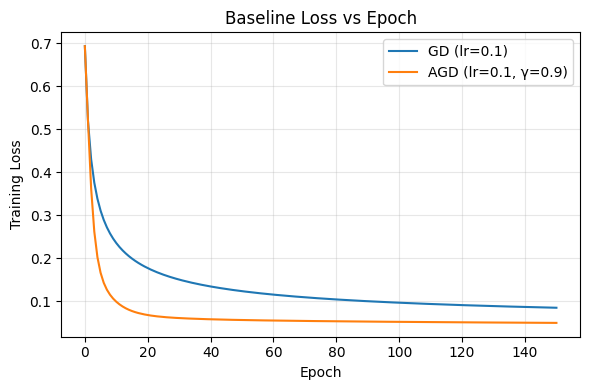

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ========== 1) Data ==========
X, y = load_breast_cancer(return_X_y=True)   # y in {0,1}
y = y.astype(np.float64)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

def add_bias(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

Xb_train = add_bias(X_train)
Xb_test  = add_bias(X_test)

# ========== 2) Loss & Grad ==========
def sigmoid(z):
    out = np.empty_like(z, dtype=np.float64)
    pos = z >= 0
    neg = ~pos
    out[pos] = 1.0 / (1.0 + np.exp(-z[pos]))
    ez = np.exp(z[neg])
    out[neg] = ez / (1.0 + ez)
    return out

def logistic_loss(w, Xb, y, lam=1e-4):
    n = Xb.shape[0]
    p = sigmoid(Xb @ w)
    eps = 1e-12
    loss = -np.mean(y*np.log(p+eps) + (1-y)*np.log(1-p+eps))
    w_reg = w.copy(); w_reg[0] = 0.0  
    return loss + 0.5*lam*np.dot(w_reg, w_reg)

def logistic_grad(w, Xb, y, lam=1e-4):
    n = Xb.shape[0]
    p = sigmoid(Xb @ w)
    grad = (Xb.T @ (p - y)) / n
    w_reg = w.copy(); w_reg[0] = 0.0
    return grad + lam*w_reg

def accuracy(w, Xb, y):
    p = sigmoid(Xb @ w)
    yhat = (p >= 0.5).astype(np.float64)
    return (yhat == y).mean()

# ========== 3) Optimizers to implement ==========
# TODO 1: Implement GD
def run_gd(Xb_tr, y_tr, lr=0.1, lam=1e-4, epochs=150):
    """
    Implement Gradient Descent for logistic regression.

    Update rule:
        x_{t+1} = x_t − lr * ∇f(x_t)

    Requirements:
    - Initialize parameters x as zeros of shape (d,).
    - For 'epochs' iterations:
        * compute gradient at current x using logistic_grad()
        * update x
        * compute training loss using logistic_loss() and append to loss_hist
    - Return (x, loss_hist)

    """
    #####################################
    w_t = np.zeros((epochs + 1, Xb_tr.shape[1]))
    loss_hist = np.zeros(epochs + 1)
    loss_hist[0] = logistic_loss(w_t[0], Xb_tr, y_tr, lam)
    for i in range(1, epochs + 1) :
        gd = logistic_grad(w_t[i - 1], Xb_tr, y_tr, lam)
        w_t[i] = w_t[i - 1] - lr * gd
        loss_hist[i] = logistic_loss(w_t[i], Xb_tr, y_tr, lam)
    return w_t[-1], loss_hist
    #####################################

# TODO 2: Implement AGD (Nesterov)
def run_agd(Xb_tr, y_tr, lr=0.1, gamma=0.9, lam=1e-4, epochs=150):
    """
    Implement Nesterov’s Accelerated Gradient for logistic regression.

    Update rules:
        y_t     = x_t + gamma * (x_t − x_{t−1})
        x_{t+1} = y_t − lr * ∇f(y_t)

    Requirements:
    - Initialize x_prev = zeros(d), x = zeros(d)
    - For 'epochs' iterations:
        * form y_t
        * compute gradient at y_t using logistic_grad()
        * update x to x_{t+1}
        * append training loss at the new x to loss_hist
    - Return (x, loss_hist)

    """
    #####################################
    x_t = np.zeros((epochs + 1, Xb_tr.shape[1]))
    loss_hist = np.zeros(epochs + 1)
    loss_hist[0] = logistic_loss(x_t[0], Xb_tr, y_tr, lam)
    for i in range(1, epochs + 1) :
        if i > 1 : 
            y_t = x_t[i - 1] + gamma * (x_t[i - 1] - x_t[i - 2])
        else :
            y_t = x_t[i - 1]
        gd = logistic_grad(y_t, Xb_tr, y_tr, lam)
        x_t[i] = y_t - lr * gd
        loss_hist[i] = logistic_loss(x_t[i], Xb_tr, y_tr, lam)
    return x_t[-1], loss_hist
    #####################################

# ========== 4) Training ==========
lam = 1e-4
epochs = 150
lr_gd = 0.1
lr_agd = 0.1
gamma = 0.9

w_gd,  loss_gd  = run_gd (Xb_train, y_train, lr=lr_gd, lam=lam, epochs=epochs)
w_agd, loss_agd = run_agd(Xb_train, y_train, lr=lr_agd, gamma=gamma, lam=lam, epochs=epochs)

print("GD:  final train acc {:.4f}, test acc {:.4f}, final train loss {:.4f}".format(
    accuracy(w_gd, Xb_train, y_train), accuracy(w_gd, Xb_test, y_test), loss_gd[-1]
))
print("AGD: final train acc {:.4f}, test acc {:.4f}, final train loss {:.4f}".format(
    accuracy(w_agd, Xb_train, y_train), accuracy(w_agd, Xb_test, y_test), loss_agd[-1]
))

plt.figure(figsize=(6,4))
plt.plot(loss_gd,  label="GD (lr=0.1)")
plt.plot(loss_agd, label="AGD (lr=0.1, γ=0.9)")
plt.xlabel("Epoch"); plt.ylabel("Training Loss"); plt.title("Baseline Loss vs Epoch")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
plt.show()

